In [7]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import comb
from networkx.algorithms import centrality

In [8]:
def get_bichromatic_ratio(g):
    bichromatic = 0
    for (x,y) in g.edges():
        if (x < size_maj) != (y < size_maj):
            bichromatic += 1
    return bichromatic / len(g.edges())

In [58]:
graph_size = 1000
maj_min_ratio = .7
size_maj = int(maj_min_ratio * graph_size)
size_min = int(graph_size - size_maj)
probs = [[0.05, 0.01],
         [0.01, 0.05]]
g = nx.generators.community.stochastic_block_model([size_maj, size_min], probs, seed=0)
centrality = centrality_types["Degree"](g)

In [60]:
get_ratio_maj_top_x_percent(t=700, x=10, d=centrality)

1.0

In [103]:
g.number_of_edges()

21404

In [9]:
def expected_bichromatic_wedges(n, p, q):
    return 2 * n * comb(n/2, 2) * p * q * (1-q)

In [10]:
def expected_monochromatic_wedges(n, p, q):
    return 3 * 2 * comb(n/2, 3) * p**2 * (1-p) + n * comb(n/2, 2) * q**2 * (1-p)

In [7]:
expected_bichromatic_wedges(graph_size, probs[0][0], probs[0][1])

244510.0

In [8]:
expected_monochromatic_wedges(graph_size, probs[0][0], probs[0][1])

342501.12500000006

In [9]:
expected_monochromatic_wedges(graph_size, probs[0][0], probs[0][1]) / (expected_monochromatic_wedges(graph_size, probs[0][0], probs[0][1]) + expected_bichromatic_wedges(graph_size, probs[0][0], probs[0][1]))

0.58346615662522594

In [10]:
iterations = 10
new_friends_per_iter = 1
alpha = 1

In [11]:
def get_group(node):
    if node < size_maj:
        return range(size_maj)
    else:
        return range(size_maj, graph_size)

In [12]:
def close_wedges(g, isalpha, alpha, iterations, new_friends_per_iter):
    bichromatic_ratios = [get_bichromatic_ratio(g)]
    for i in range(iterations):
        # Select random node
        node = np.random.randint(0, g.number_of_nodes())
        edges_added = 0
        # Add edges of friends of friends randomly
        while (edges_added < new_friends_per_iter):
            if isalpha:
                same_type = np.random.binomial(1, alpha)
                if same_type:
                    friends = set(nx.all_neighbors(g, node)).intersection(set(get_group(node)))
                else:
                    friends = set(nx.all_neighbors(g, node)).difference(set(get_group(node)))
            else:
                friends = set(nx.all_neighbors(g, node))
            if len(friends) > 0:
                friend = random.sample(friends, 1)[0]
                new_possible_friends = set(nx.all_neighbors(g, friend)).difference(set(nx.all_neighbors(g, node)))
                if len(new_possible_friends) > 0:
                    new_friend = random.sample(new_possible_friends, 1)[0]
                    g.add_edge(node, new_friend)
                    edges_added += 1
                else:
                    node = np.random.randint(0, g.number_of_nodes())
            else:
                node = np.random.randint(0, g.number_of_nodes())
        bichromatic_ratios.append(get_bichromatic_ratio(g))
    return bichromatic_ratios

In [13]:
def close_wedges_simultaneously(g, n):
    edges_to_add = []
    while (len(edges_to_add) < n):
        node = np.random.randint(0, g.number_of_nodes())
        friends = set(nx.all_neighbors(g, node))
        if len(friends) > 0:
            friend = random.sample(friends, 1)[0]
            new_possible_friends = set(nx.all_neighbors(g, friend)).difference(set(nx.all_neighbors(g, node)))
            if len(new_possible_friends) > 0:
                new_friend = random.sample(new_possible_friends, 1)[0]
                edges_to_add.append((node, new_friend))
    g.add_edges_from(edges_to_add)
    return g

In [14]:
def plot_bichromatic_ratios_sbm(sample_size, graph_size, maj_min_ratio, probs, iterations=None, new_friends_per_iter=None, n=None):
    size_maj = int(maj_min_ratio * graph_size)
    size_min = int(graph_size - size_maj)
    bichromatic_ratio_matrix = []
    for seed in range(sample_size):
        g = nx.generators.community.stochastic_block_model([size_maj, size_min], probs, seed=seed)
        if n:
            bichromatic_ratio_matrix.append([get_bichromatic_ratio(g), get_bichromatic_ratio(close_wedges_simultaneously(g, n))])
        else:
            bichromatic_ratio_matrix.append(close_wedges(g, False, 1, iterations, new_friends_per_iter))
    bichromatic_ratios = np.average(bichromatic_ratio_matrix, axis=0)
    file_name = "plots/sbm_p=" + str(int(100*probs[0][0])) + "_q=" + str(int(100*probs[0][1])) + "biratio_maj_" + str(int(maj_min_ratio * 100)) + "g" + str(graph_size) + "_sample" + str(sample_size) 
    if n:
        file_name += "_simul"
    print(bichromatic_ratios)
    plt.plot(range(len(bichromatic_ratios)), bichromatic_ratios)
    plt.xlabel("Iterations")
    plt.ylabel("Ratio of Bichromatic Edges")
    plt.title("Ratio of Bichromatic Edges for " + str(int(maj_min_ratio * 100)) + "% Majority, p=" +str(probs[0][0]) + " q=" + str(probs[0][1]))
    # plt.savefig("plots/bichromatic_ratio_maj_" + str(int(maj_min_ratio * 100)) + "g" + str(graph_size) + "_iters" + str(iterations) + "_type_bias" + "_alpha" + str(int(10 * alpha)))
    plt.savefig(file_name)
    plt.show()

[ 0.16656141  0.16725096]


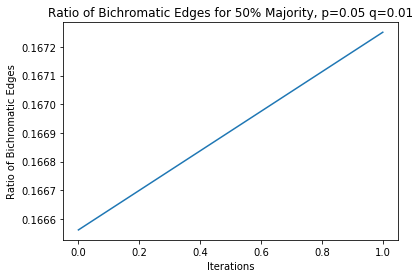

In [31]:
plot_bichromatic_ratios_sbm(50, 1000, .5, [[0.05, 0.01],[0.01, 0.05]], n=100)

[ 0.16656141  0.16656366  0.1665752   0.16658547  0.16659031  0.16659789
  0.16660547  0.16660502  0.16661258  0.16662548  0.1666317   0.16664057
  0.16664544  0.16665835  0.16666323  0.16667748  0.16668641  0.16669535
  0.16670828  0.16671318  0.16671938  0.16672694  0.16673317  0.16673936
  0.16675227  0.16675048  0.16675401  0.16676027  0.16676511  0.16677667
  0.16678286  0.16679581  0.16680597  0.16680954  0.16681571  0.16682323
  0.16682677  0.16682897  0.16683654  0.16683873  0.16684499  0.16685249
  0.16686538  0.16686759  0.1668751   0.16687997  0.16689151  0.16689765
  0.16690254  0.16691008  0.16691495  0.16691844  0.16693128  0.16694282
  0.16694768  0.16695786  0.16695873  0.16697292  0.16698311  0.16698794
  0.16699146  0.1669923   0.16699315  0.16700332  0.1670148   0.16702235
  0.16702721  0.16703204  0.16704217  0.16704573  0.16705324  0.16706474
  0.16707621  0.16708636  0.16708989  0.16709735  0.16709957  0.16710441
  0.16710394  0.16711012  0.16712165  0.16712514  0

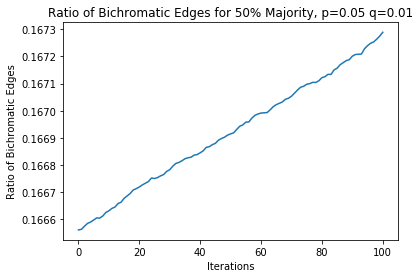

In [28]:
plot_bichromatic_ratios_sbm(50, 1000, .5, [[0.05, 0.01],[0.01, 0.05]], 100, 1)

In [15]:
def get_ave_value(key_range, d):
    values = []
    for key in key_range:
        values.append(d[key])
    return np.average(values)

In [16]:
centrality_types = {
    "Degree": centrality.degree_centrality,
    "Eigenvector": centrality.eigenvector_centrality,
    "Katz": centrality.katz_centrality,
    "Closeness": centrality.closeness_centrality,
#     "Flow-Closeness": centrality.current_flow_closeness_centrality,
    "Betweenness": centrality.betweenness_centrality,
#     "Flow-Betweenness": centrality.current_flow_betweenness_centrality
}

In [17]:
len(centrality_types)

5

In [17]:
def get_ratio_maj_top_x_percent(t, x, d):
    count = 0
    sorted_d = sorted(d.items(), key=lambda x: x[1])
    sorted_d.reverse()
    for tup in sorted_d[:round(x * len(d) / 100)]:
        if tup[0] < t:
            count += 1
    return count / round(x * len(d) / 100)

In [18]:
def get_centrality_types():
    return {
        "Degree": centrality.degree_centrality,
        "Eigenvector": centrality.eigenvector_centrality,
#         "Katz": centrality.katz_centrality,
        "Closeness": centrality.closeness_centrality,
#         "Flow-Closeness": centrality.current_flow_closeness_centrality,
        "Betweenness": centrality.betweenness_centrality,
#         "Flow-Betweenness": centrality.current_flow_betweenness_centrality
    }

In [37]:
def get_maj_min_centrality(graph_size, probs, centrality_type, maj_min_ratios, wedges=0):
    maj_ave_centrality = []
    min_ave_centrality = []
    for maj_min_ratio in maj_min_ratios:
        size_maj = int(maj_min_ratio * graph_size)
        size_min = int(graph_size - size_maj)
        maj_aves = []
        min_aves = []
        for seed in range(10):
            g = nx.generators.community.stochastic_block_model([size_maj, size_min], probs, seed=seed)
            if wedges > 0:
                g = close_wedges_simultaneously(g, wedges)
            node_centrality = get_centrality_types()[centrality_type](g)
            maj_aves.append(get_ave_value(range(size_maj), node_centrality))
            min_aves.append(get_ave_value(range(size_maj, graph_size), node_centrality))
        print(maj_aves)
        maj_ave_centrality.append(np.average(maj_aves))
        min_ave_centrality.append(np.average(min_aves))
    return np.array(maj_ave_centrality), np.array(min_ave_centrality)

In [20]:
def get_maj_ratios(graph_size, probs, centrality_type, maj_min_ratios, top_percents, wedges=0):
    maj_proportions_matrix = []
    # Can make this faster! Accidentally inverted the loops eek
    for top_percent in top_percents:
        maj_proportions = []
        for maj_min_ratio in maj_min_ratios:
            size_maj = int(maj_min_ratio * graph_size)
            size_min = int(graph_size - size_maj)
            g = nx.generators.community.stochastic_block_model([size_maj, size_min], probs, seed=0)
            if wedges > 0:
                g = close_wedges_simultaneously(g, wedges)
            node_centrality = get_centrality_types()[centrality_type](g)
            maj_proportions.append(get_ratio_maj_top_x_percent(size_maj, top_percent, node_centrality))
        maj_proportions_matrix.append(maj_proportions)
    return np.array(maj_proportions_matrix)

In [6]:
get_ratio_maj_top_x_percent(500, 10, get_centrality_types()["Degree"](g))

NameError: name 'get_ratio_maj_top_x_percent' is not defined

In [102]:
get_maj_ratios(1000, [[0.05, 0.01],[0.01, 0.05]], "Degree", np.arange(.5, 1, .05), [10, 25, 50])

array([[ 0.47 ,  0.82 ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
         1.   ,  1.   ],
       [ 0.504,  0.744,  0.956,  1.   ,  1.   ,  1.   ,  1.   ,  1.   ,
         1.   ,  1.   ],
       [ 0.458,  0.666,  0.862,  0.972,  1.   ,  1.   ,  1.   ,  1.   ,
         1.   ,  1.   ]])

In [21]:
def plot_maj_ratios(graph_size, probs, centrality_type, maj_min_ratios, top_percents, wedges=[]):
    maj_proportions = get_maj_ratios(
        graph_size, 
        probs, 
        centrality_type, 
        maj_min_ratios,
        top_percents)
    for i in range(len(maj_proportions)):
        plt.plot(maj_min_ratios, maj_proportions[i], label="top " + str(top_percents[i]) + "%")
#     else:
#         maj_proportions = get_maj_ratios(
#             graph_size, 
#             probs, 
#             centrality_type, 
#             maj_min_ratios,
#             top_percent)
#         plt.plot(maj_min_ratios, maj_proportions)
    plt.xlabel("Majority Ratio")
    plt.ylabel("Majority Proportion")
    plt.title("Majority Proportion of Most Central Nodes Under " + centrality_type + " Centrality, p=" + str(probs[0][0]) + ", q=" + str(probs[0][1]))
    plt.legend()
    file_name = centrality_type + "_centrality_maj_prop_p=" + str(int(100*probs[0][0])) + "_q=" + str(int(100*probs[0][1])) + "_g" + str(graph_size) + "perc=" + str(top_percents)
    if len(wedges) > 1:
        file_name += "_wedges=" + str(wedges)
    plt.savefig("plots/" + file_name)
    plt.show() 

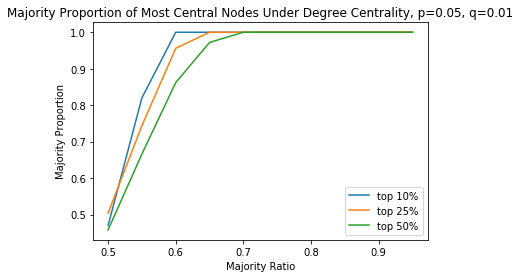

In [104]:
plot_maj_ratios(1000, [[0.05, 0.01],[0.01, 0.05]], "Degree", np.arange(.5, 1, .05), [10, 25, 50])

In [22]:
def plot_centrality_difference(graph_size, probs, centrality_type, maj_min_ratios, wedges=[]):
    if wedges:
        for i in wedges:
            maj_ave_centrality, min_ave_centrality = get_maj_min_centrality(
                graph_size, 
                probs, 
                centrality_type, 
                maj_min_ratios, 
                i)
            print(maj_ave_centrality, min_ave_centrality)
            plt.plot(maj_min_ratios, maj_ave_centrality - min_ave_centrality, label="majority - minority (w=" + str(i) + ")")
    else:
        maj_ave_centrality, min_ave_centrality = get_maj_min_centrality(
            graph_size, 
            probs, 
            centrality_type, 
            maj_min_ratios)
        plt.plot(maj_min_ratios, maj_ave_centrality - min_ave_centrality)
        plt.plot(maj_min_ratios, min_ave_centrality, label="Minority")
    plt.xlabel("Majority Ratio")
    plt.ylabel("Average " + centrality_type + " Centrality Difference")
    plt.title("Average " + centrality_type + " Centrality Difference, p=" + str(probs[0][0]) + ", q=" + str(probs[0][1]))
    plt.legend()
    file_name = centrality_type + "_centrality_diff_p=" + str(int(100*probs[0][0])) + "_q=" + str(int(100*probs[0][1])) + "_g" + str(graph_size)
    if len(wedges) > 1:
        file_name += "_wedges=" + str(wedges)
    plt.savefig("plots/" + file_name)
    plt.show()

In [23]:
def plot_centrality(graph_size, probs, centrality_type, maj_min_ratios, wedges=[]):
    if wedges:
        for i in wedges:
            maj_ave_centrality, min_ave_centrality = get_maj_min_centrality(
                graph_size, 
                probs, 
                centrality_type, 
                maj_min_ratios, 
                i)
            print(maj_ave_centrality, min_ave_centrality)
            plt.plot(maj_min_ratios, maj_ave_centrality, label="Majority (w=" + str(i) + ")")
            plt.plot(maj_min_ratios, min_ave_centrality, label="Minority (w=" + str(i) + ")")
    else:
        maj_ave_centrality, min_ave_centrality = get_maj_min_centrality(
            graph_size, 
            probs, 
            centrality_type, 
            maj_min_ratios)
        plt.plot(maj_min_ratios, maj_ave_centrality, label="Majority")
        plt.plot(maj_min_ratios, min_ave_centrality, label="Minority")
    plt.xlabel("Majority Ratio")
    plt.ylabel("Average " + centrality_type + " Centrality")
    plt.title("Average " + centrality_type + " Centrality, p=" + str(probs[0][0]) + ", q=" + str(probs[0][1]))
    plt.legend()
    file_name = centrality_type + "_centrality_p=" + str(int(100*probs[0][0])) + "_q=" + str(int(100*probs[0][1])) + "_g" + str(graph_size)
    if len(wedges) > 1:
        file_name += "_wedges=" + str(wedges)
    plt.savefig("plots/" + file_name)
    plt.show()

In [35]:
t_1000_p_matrix = [[0.54, 0.42],[0.42, 0.54]]
t_5_p_matrix = [[.03, .02], [.02, .03]]

[0.47809467179171355, 0.4779778716897789, 0.48161991123192255, 0.48080231051838013, 0.48000594618700754, 0.48011212809785725, 0.4799740916137526, 0.482097729830746, 0.48260740300282445, 0.47999532799592259]
[0.48397701637005192, 0.48478684225748608, 0.48883597169465703, 0.48704278580105276, 0.48519175520120317, 0.48505678421996418, 0.48434336617627222, 0.48889381640090235, 0.48904806895088981, 0.48604014422613429]
[0.48945918745696276, 0.4915073185373518, 0.49488850045023569, 0.49337005844236104, 0.49316701096456378, 0.48998004837826858, 0.49174567861998347, 0.49456185885551851, 0.49565654960538164, 0.49286685382347228]
[0.49740987678530579, 0.49979573160767399, 0.50075170768375987, 0.49941170703010102, 0.49908487760237935, 0.49497499754877927, 0.49820243814753074, 0.49731182795698925, 0.49933817040886358, 0.49822695035460995]
[0.50351685665777335, 0.50513885520252233, 0.50519949066213921, 0.50416110841620176, 0.50551782682512736, 0.50134155954402138, 0.50321367935968953, 0.50485083676

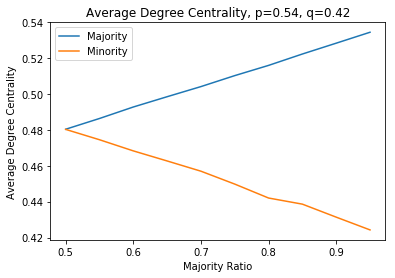

[0.047804768307813182, 0.04790832990377137, 0.04803779552408504, 0.047950916746167353, 0.047972873023995569, 0.047594097643995324, 0.047843405376503029, 0.04794853065468109, 0.048029719886143324, 0.047846658543225971]
[0.04842788026525973, 0.048502884857815558, 0.048600755754944686, 0.048515126944466289, 0.048592784344758944, 0.048228320104081082, 0.048435005258470436, 0.048583447476559169, 0.048556624561747343, 0.048431878847645687]
[0.048910695889254674, 0.048989287727018604, 0.049035476796443857, 0.048906890067706682, 0.049079240222141378, 0.048763373118300639, 0.048887466512325596, 0.049059844118474354, 0.04912930036030623, 0.048897503792274255]
[0.049225235640456125, 0.049263434040683132, 0.049225443456644292, 0.049158624238851201, 0.049328083710407089, 0.049068246140339146, 0.049196742637204562, 0.04933321345382799, 0.04942702382165351, 0.049186763702993762]
[0.049431579153662031, 0.049390527195454205, 0.049360709313764156, 0.049324292413828998, 0.049416092709489941, 0.0492029304

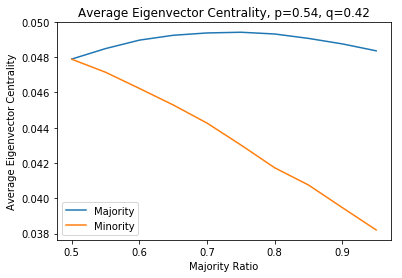

[0.65721404221158197, 0.6571812558045953, 0.65873557607572797, 0.6584078644377992, 0.65805841143281829, 0.65811786588812438, 0.65805864876041698, 0.65895746505826069, 0.65917352359388015, 0.65804217306558777]
[0.65977770201260244, 0.66013440468658502, 0.66190713151549796, 0.66114448211578958, 0.66032991775035255, 0.66027851009104011, 0.65994495425787836, 0.66194426620424218, 0.66200504251375025, 0.66067821580061892]
[0.66216740008769814, 0.66309473183923873, 0.66454543708491187, 0.66391212545553269, 0.66381353965033418, 0.66239952046154438, 0.6631824630757619, 0.66442164228574252, 0.66489315220582945, 0.66369442041510451]
[0.66567468585163425, 0.66674408085282788, 0.66715861974681601, 0.66656155871347633, 0.6664298907063293, 0.66461553801425743, 0.66602653987464044, 0.6656351131143341, 0.66657497622094986, 0.66603884376578182]
[0.6683896789179099, 0.66913206895704902, 0.6691460643392918, 0.66871143212890349, 0.66928492650752625, 0.66742145829337274, 0.66827261668044646, 0.6689792041377

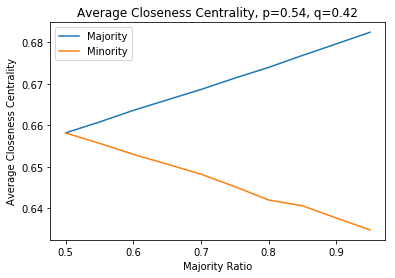

[0.0012001379052814917, 0.0012074537862017828, 0.0012056648062444596, 0.0012028422644044493, 0.0012043992010628032, 0.001184615585919719, 0.0011987017481611584, 0.0011995878453653884, 0.0012006236035663346, 0.0011992730899894411]
[0.0012192105172907455, 0.0012248849654132813, 0.0012202186499817244, 0.0012197598307155159, 0.0012271739538770676, 0.0012079273525768546, 0.0012203779902405659, 0.0012189671308026697, 0.0012150384884347435, 0.0012172451175598697]
[0.0012352255095005777, 0.0012380058118308369, 0.0012314075725975827, 0.0012277756899223568, 0.0012365083979742929, 0.001226733661143513, 0.001229218763297591, 0.0012323075674244566, 0.0012330119464745849, 0.001227062447240673]
[0.0012367613386292866, 0.0012343456331216957, 0.0012286689941042211, 0.0012289136904017628, 0.0012392318616224057, 0.0012336948927701989, 0.0012335220631609881, 0.0012437114775329886, 0.0012449031013114916, 0.0012313302278477356]
[0.0012367915252493652, 0.00123180600279009, 0.0012291141036022927, 0.0012299494

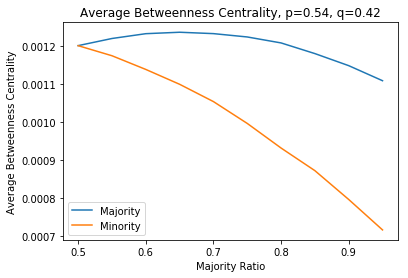

In [38]:
for centrality_type in get_centrality_types():
    try:
        plot_centrality(435, t_1000_p_matrix, centrality_type, np.arange(.5, 1, .05))
    except:
        print("exception occurred for " + centrality_type)

[ 0.00552352  0.00596961  0.00647814  0.00701471  0.00736308  0.00780914
  0.00828829  0.00875464  0.00919697  0.00966229] [ 0.00564364  0.00519186  0.00451201  0.00409838  0.00355355  0.00326326
  0.00312312  0.00252252  0.00185185  0.00128128]
[ 0.00570571  0.00616617  0.00665999  0.00721337  0.00757186  0.00801335
  0.00850225  0.00897132  0.00941275  0.00987303] [ 0.00586186  0.00539651  0.00472973  0.00430144  0.00373373  0.00344344
  0.00326827  0.00261595  0.00191191  0.00128128]
[ 0.00737738  0.00791155  0.00847014  0.00905059  0.00942228  0.00981782
  0.0103028   0.01078726  0.01122233  0.0116664 ] [ 0.00763764  0.00709376  0.00632382  0.00588875  0.0050684   0.004997
  0.00472472  0.0040307   0.00298298  0.00224224]


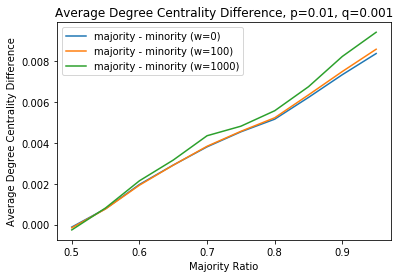

In [94]:
plot_centrality_difference(1000, [[0.05, 0.01],[0.01, 0.05]], "Degree", np.arange(.5, 1, .05), [0,100,1000])

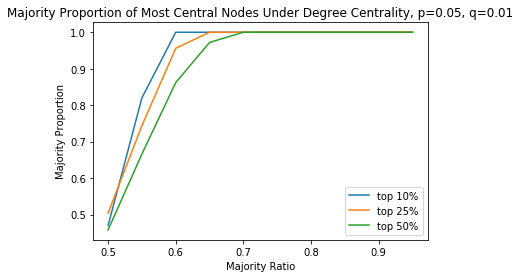

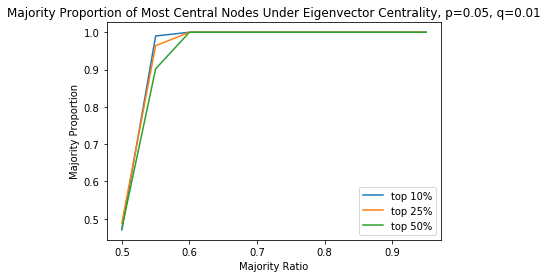

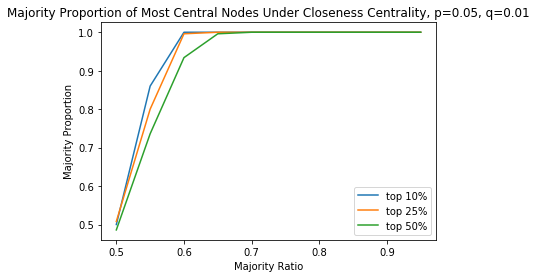

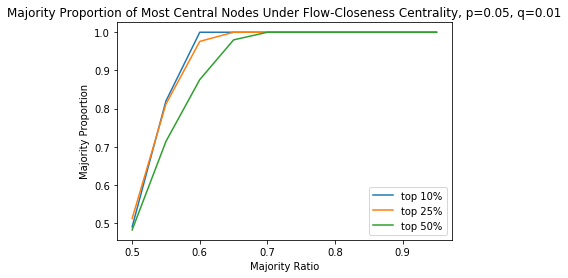

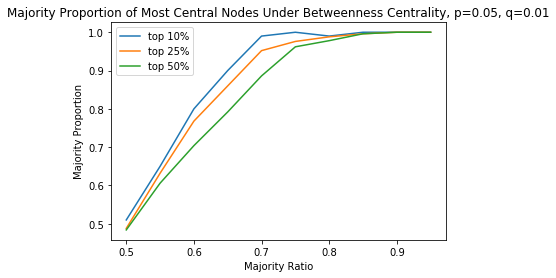

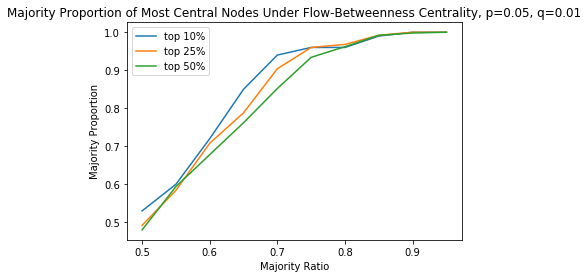

In [105]:
for centrality_type in get_centrality_types():
    try:
        plot_maj_ratios(1000, [[0.05, 0.01],[0.01, 0.05]], centrality_type, np.arange(.5, 1, .05), [10, 25, 50])
    except:
        print("exception occurred for " + centrality_type)

In [607]:
np.arange(.5, 1, .1)

array([ 0.5,  0.6,  0.7,  0.8,  0.9])

In [645]:
centrality_types = {
    "degree": centrality.degree_centrality,
    "eigenvector": nx.algorithms.centrality.eigenvector_centrality,
    "katz": nx.algorithms.centrality.katz_centrality
}